In [3]:
import sys
sys.executable

'/usr/bin/python3.6'

In [6]:
import librosa
import numpy as np
import os
import scipy.io.wavfile as sio

cleans = os.listdir("DAE-libri-cp")[:160]
noisy = os.listdir("dataset")[:160]
cleans = [sio.read("./DAE-libri-cp/" + x)[1].astype(np.float32) / 2**15 for x in cleans]
noisy = [sio.read("./dataset/" + x)[1].astype(np.float32) / 2**15 for x in noisy]
cleans = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for x in cleans for i in range(6)]
noisy = [np.abs(librosa.stft(x, n_fft=512, hop_length=128).T) for record in noisy for x in record.T]

In [ ]:
maxlen = max([x.shape[0] for x in cleans])
cleans = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in cleans])
noisy = np.stack([np.pad(x, ((maxlen - x.shape[0], 0), (0, 0)), mode='constant', constant_values=0) for x in noisy])

In [14]:
masks = np.clip(cleans / (noisy + 2e-12), 0, 1)

In [33]:
import keras
from keras.layers import Dense, LSTM, Conv2D, LeakyReLU, BatchNormalization, Flatten, TimeDistributed, Lambda
from keras.regularizers import L1L2

model = keras.models.Sequential()
model.add(Lambda(keras.backend.expand_dims, input_shape=(None, 257)))
model.add(Conv2D(8, (5,1), padding='same', activation='linear'))
model.add(LeakyReLU(0.01))
model.add(BatchNormalization())
model.add(Conv2D(8, (5,1), padding='same', activation='linear'))
model.add(LeakyReLU(0.01))
model.add(BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(Dense(512, kernel_regularizer=L1L2(l1=1e-6)))
model.add(LeakyReLU(0.01))
model.add(BatchNormalization())
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6)))
model.add(BatchNormalization())
model.add(LSTM(512, return_sequences=True, kernel_regularizer=L1L2(l1=1e-6)))
model.add(BatchNormalization())
model.add(LSTM(257, activation='sigmoid', return_sequences=True))
model.compile(keras.optimizers.Adam(3e-4, clipnorm=1.), 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, None, 257, 1)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, 257, 8)      48        
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, None, 257, 8)      0         
_________________________________________________________________
batch_normalization_36 (Batc (None, None, 257, 8)      32        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, 257, 8)      328       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, None, 257, 8)      0         
_________________________________________________________________
batch_normalization_37 (Batc (None, None, 257, 8)      32        
__________

In [35]:
model.fit(noisy[:500], masks[:500], epochs=20, batch_size=8, validation_data=[noisy[500:], masks[500:]])

Train on 500 samples, validate on 40 samples
Epoch 1/20
500/500 [==============================] - 430s 860ms/step - loss: 0.1503 - val_loss: 0.1453
Epoch 2/20
500/500 [==============================] - 422s 845ms/step - loss: 0.1252 - val_loss: 0.1248
Epoch 3/20
500/500 [==============================] - 424s 847ms/step - loss: 0.1120 - val_loss: 0.1123
Epoch 4/20
500/500 [==============================] - 425s 849ms/step - loss: 0.1014 - val_loss: 0.1071
Epoch 5/20
500/500 [==============================] - 423s 846ms/step - loss: 0.0928 - val_loss: 0.1017
Epoch 6/20
500/500 [==============================] - 423s 846ms/step - loss: 0.0855 - val_loss: 0.0956
Epoch 7/20
500/500 [==============================] - 424s 848ms/step - loss: 0.0809 - val_loss: 0.0907
Epoch 8/20
500/500 [==============================] - 423s 845ms/step - loss: 0.0771 - val_loss: 0.0831
Epoch 9/20
500/500 [==============================] - 424s 848ms/step - loss: 0.0731 - val_loss: 0.0809
Epoch 10/20
500/500

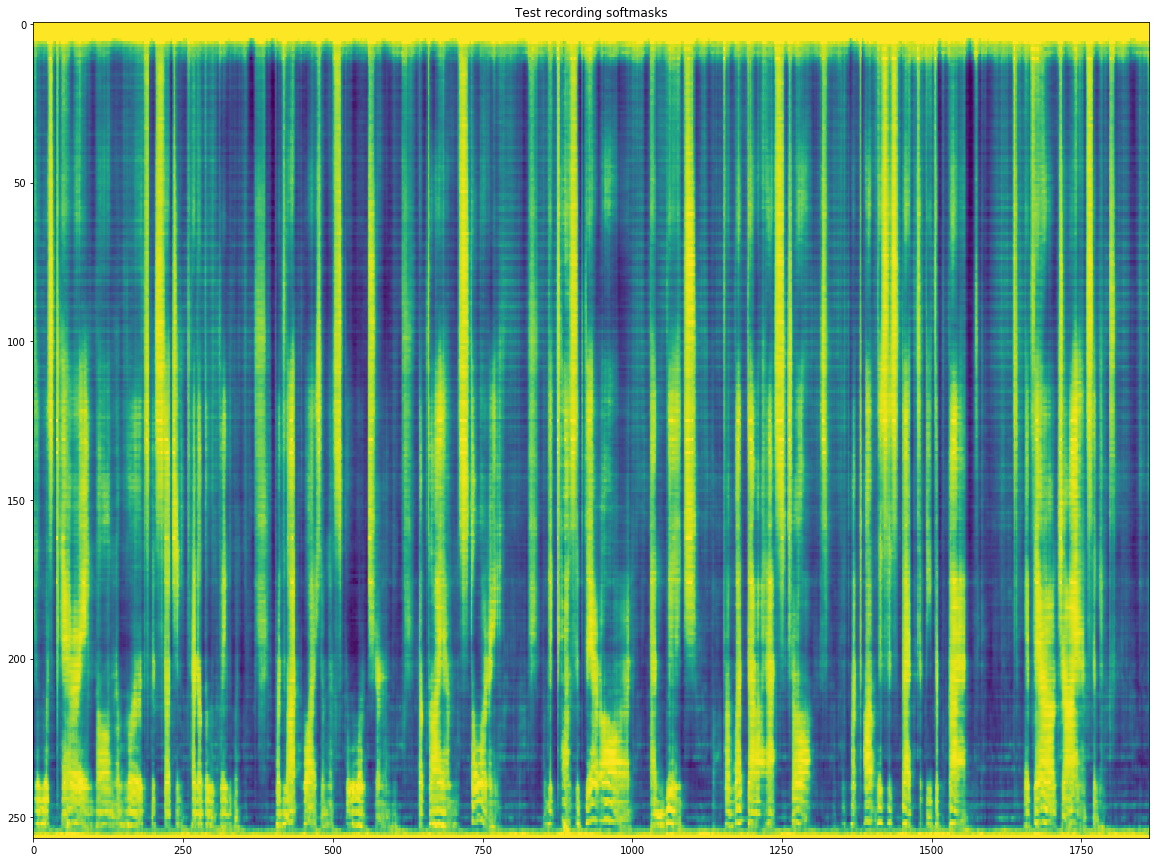

In [53]:
import matplotlib.pyplot as plt
a = model.predict(noisy[520:521])[0]
plt.figure(figsize=(20,15))
plt.imshow(np.flip(a.T[:, 230:], 0), aspect='auto')
plt.title("Test recording softmasks")
plt.show()

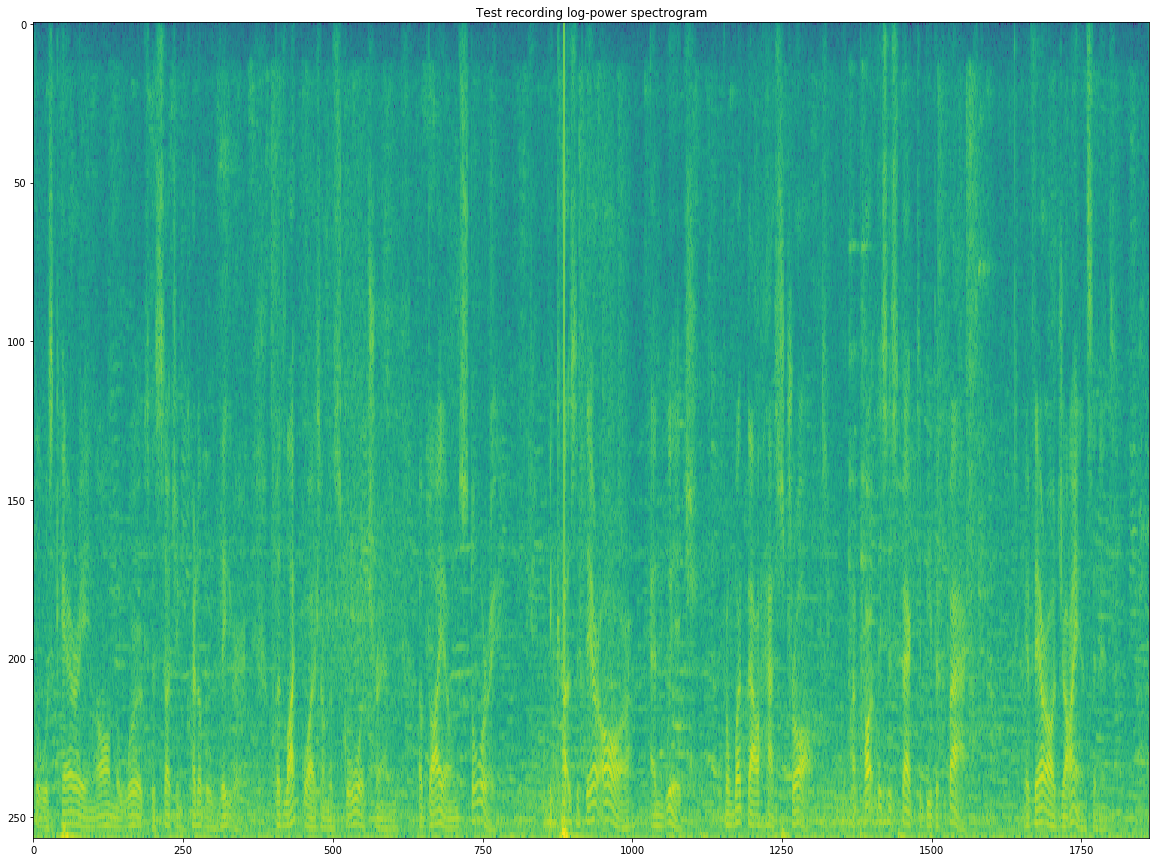

In [49]:
plt.figure(figsize=(20,15))
plt.imshow(np.flip(np.log(noisy[520:521][0].T[:, 230:]**2 + 2e-12), 0), aspect='auto')
plt.title("Test recording log-power spectrogram")
plt.show()

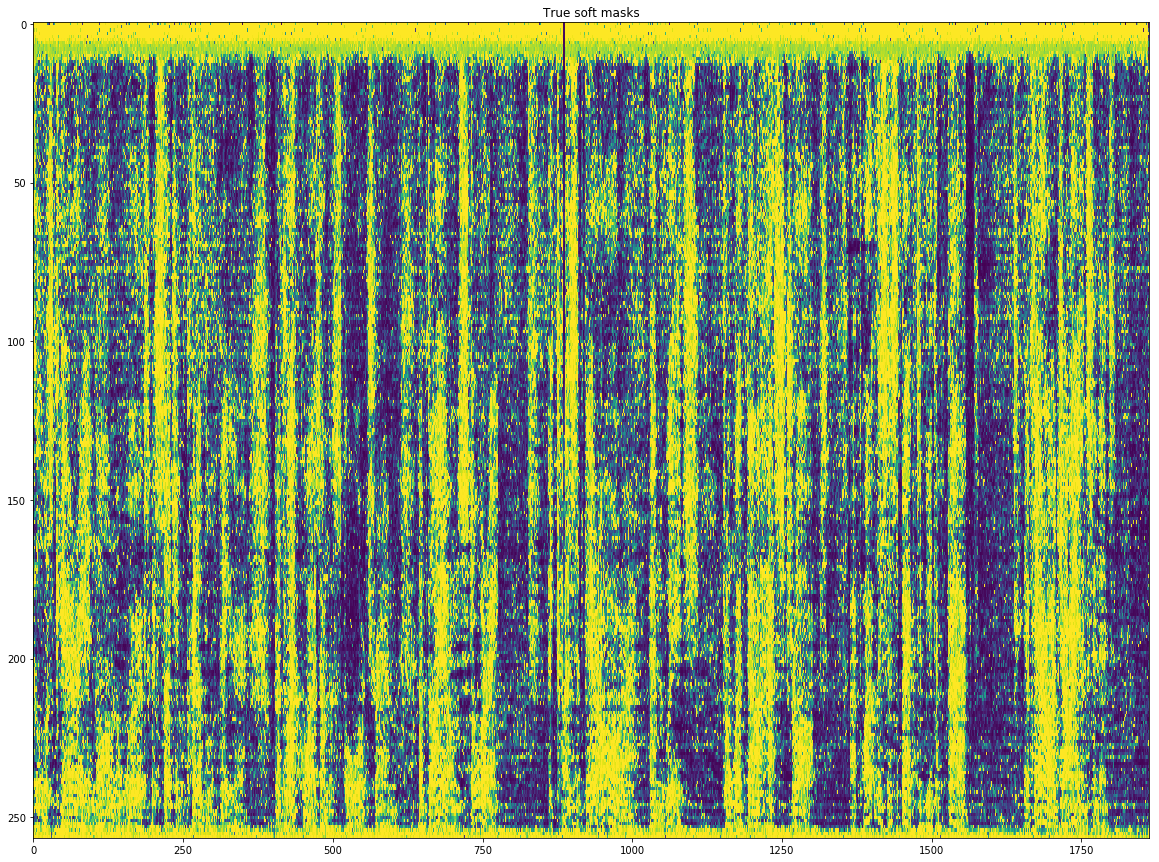

In [54]:
plt.figure(figsize=(20,15))
plt.imshow(np.flip(masks[520:521][0].T[:, 230:], 0), aspect='auto')
plt.title("True soft masks")
plt.show()

In [108]:
r = os.listdir("DASHnoisy")[520 // 6 + int(bool(520 % 6)) - 1]
d = sio.read("DASHnoisy/" + r)[1]
spec = librosa.stft(d.astype(np.float32).T[4] / 2**15, n_fft=512, hop_length=128).T
spec2 = a[-1934:]* spec
### mask = abs(clean) / abs(noise)
### abs(clean) = mask * abs(noise)
sound = librosa.istft(spec2.T, hop_length=128)

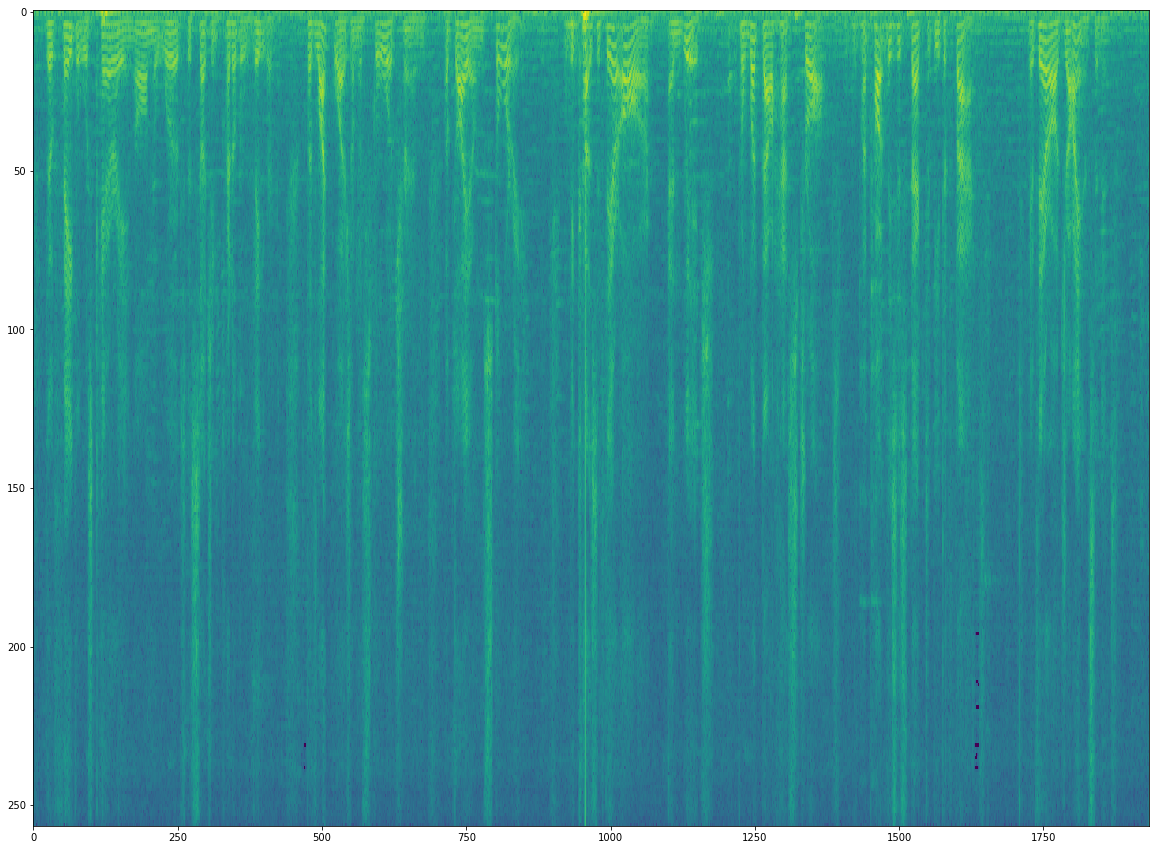

In [109]:
plt.figure(figsize=(20,15))
plt.imshow(np.abs(spec2.T)**0.1, aspect='auto')

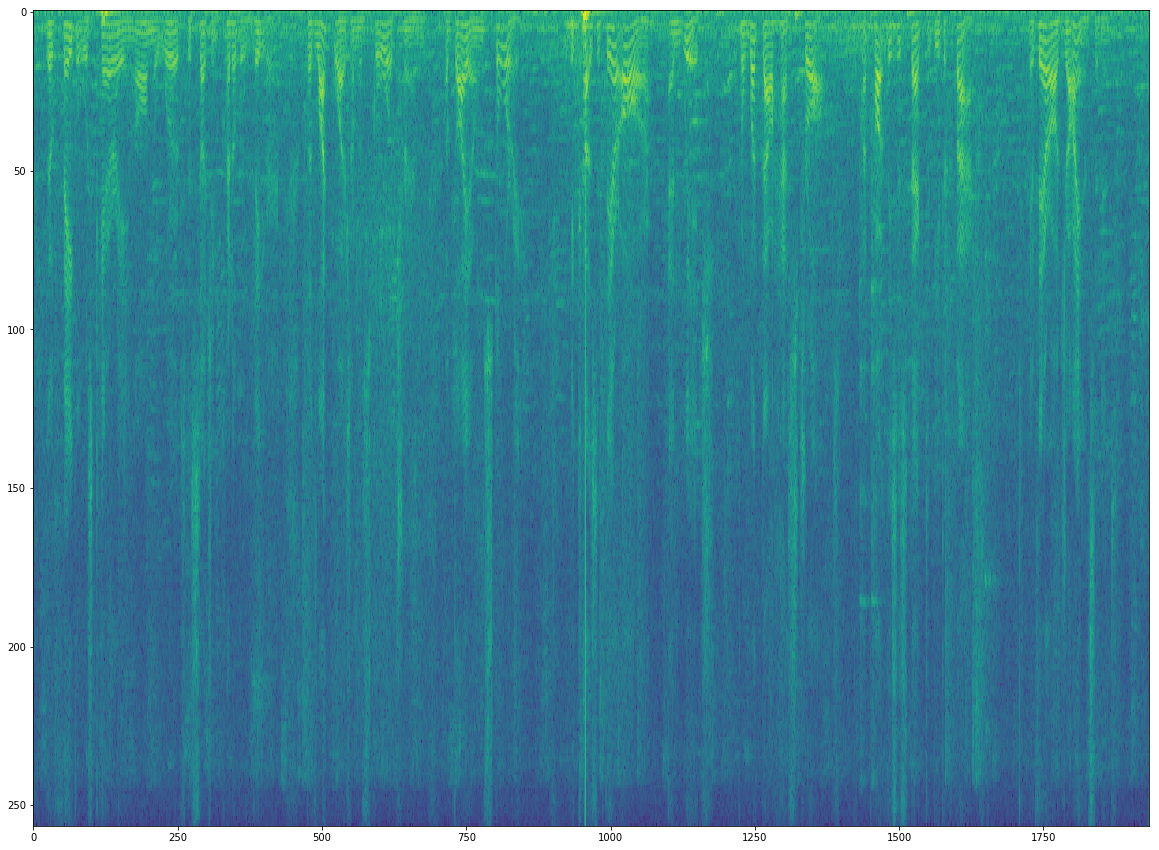

In [110]:
plt.figure(figsize=(20,15))
plt.imshow(np.abs(spec.T)**0.1, aspect='auto')

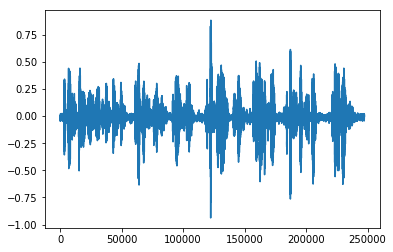

In [111]:
plt.plot(sound)
from IPython.display import display, Audio
display(Audio(sound, rate=16000))

In [113]:
display(Audio(d.T[4], rate=16000))

In [115]:
model.save("lstm.masking.harder.h5") # model on GoogleDrive